# $Importation$ $des$ $bibliothèques$

In [38]:
# Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt  # Pour tracer des graphiques
import numpy as np  # Pour manipuler des tableaux multidimensionnels
from sklearn.cluster import KMeans  # Pour effectuer le clustering KMeans
from PIL import Image  # Pour manipuler des images
import os  # Pour accéder aux fonctionnalités du système d'exploitation
import cv2  # Pour la manipulation d'images (OpenCV)

# $Données/Informations$ $utilisées$ $pour$ $le$ $programme$

In [39]:
# Chemins des fichiers d'entrée et de sortie
input_image_path = 'eren_rgb.jpg'  # Chemin de l'image d'entrée
input_irm_path = 'file.irm'  # Chemin du fichier IRM d'entrée
output_image_path = 'reconstituted.jpg'  # Chemin de l'image de sortie reconstruite

# $Caratéristiques$ $de$ $l'image$

In [40]:
def image_details(path):
    # Ouvrir l'image à partir du chemin donné
    img = Image.open(path)
    
    # Obtenir la taille de l'image (largeur, hauteur)
    size = img.size
    
    # Obtenir le format de l'image (JPEG, PNG, etc.)
    format = img.format
    
    # Obtenir le mode de l'image (RGB, L, etc.)
    mode = img.mode
    
    # Obtenir la résolution de l'image si disponible (en DPI)
    resolution = img.info.get('dpi')
    
    # Calculer la définition de l'image (nombre total de pixels)
    definition = size[0] * size[1]
    
    # Stocker également la taille originale de l'image
    definition2 = size
    
    # Si la résolution est disponible, ajuster la taille en fonction de la résolution
    if resolution is not None:
        size = (size[0] / resolution[0], size[1] / resolution[1])
    else:
        size = (0, 0)  # ou toute résolution par défaut que vous souhaitez utiliser
    
    # Obtenir la taille du fichier en kilobytes
    poids = os.path.getsize(path) / 1000.0
    
    # Calculer le nombre total de bits de l'image
    if mode == 'RGB':
        trsc = definition * 3 * img.bits
    else:
        trsc = definition * 1 * img.bits
    
    # Convertir le nombre total de bits en kilobits
    trsc /= (1024 * 8)
    
    # Calculer le taux de compression en pourcentage
    taux_compression = 100 * (1 - (poids / trsc))
    
    # Retourner toutes les informations collectées sous forme de tuple
    return size, format, mode, resolution, definition, definition2, poids, trsc, taux_compression

# $Affichage$ $de$ $deux$ $images$ $quelconques$ $côte$ $à$ $côte$

In [41]:
def plot_images(original_path, modified_path):
    # Ouvrir l'image originale depuis le chemin spécifié
    img1 = Image.open(original_path)
    
    # Ouvrir l'image modifiée (reconstruite) depuis le chemin spécifié
    img2 = Image.open(modified_path)
    
    # Créer une figure et des sous-graphiques pour afficher les deux images côte à côte
    fig, axs = plt.subplots(1, 2, figsize=(30, 15))  # Créer une figure avec une rangée et deux colonnes
    fig.subplots_adjust(wspace=0.01)  # Ajuster l'espace entre les sous-graphiques
    
    # Afficher l'image originale dans le premier sous-graphique
    axs[0].imshow(img1)
    axs[0].set_title('Image initiale')  # Définir le titre du premier sous-graphique
    axs[0].axis('off')  # Désactiver les axes du premier sous-graphique
    
    # Afficher l'image reconstruite dans le deuxième sous-graphique
    axs[1].imshow(img2)
    axs[1].set_title('Image reconstruite')  # Définir le titre du deuxième sous-graphique
    axs[1].axis('off')  # Désactiver les axes du deuxième sous-graphique
    
    # Ajuster la disposition de la figure pour éviter les chevauchements
    fig.tight_layout()
    
    # Afficher la figure avec les deux images
    plt.show()

## $Mean$ $Square$ $Error$ $(MSE):$ $Erreur$ $Quadratique$ $Moyenne$

In [42]:
def MSE(original_image_path, processed_image_path):
    # Charger les images
    image_originale = Image.open(original_image_path)
    image_traitee = Image.open(processed_image_path)

    # Convertir les images en tableaux NumPy
    origine = np.array(image_originale)
    traitee = np.array(image_traitee)

    # Assurer que les images ont les mêmes dimensions
    if origine.shape != traitee.shape:
        raise ValueError("Les dimensions des images sont différentes.")

    # Calculer la somme des différences au carré
    somme_differences_carrees = np.sum((origine.astype(np.float32) - traitee.astype(np.float32)) ** 2)

    # Calculer (1 / (L * C)) * somme
    resultat = (1 / (origine.shape[0] * origine.shape[1])) * somme_differences_carrees

    return resultat

## $Taux$ $de$ $compression$ $par$ $rapport$ $aux$ $données$ $des$ $fichiers$

In [43]:
def compression_ratio(chemin_image, chemin_donnees_compressées):
    # Ouvrir l'image depuis le chemin spécifié
    img = Image.open(chemin_image)
    
    # Déterminer la taille des pixels en fonction du mode de couleur de l'image
    if img.mode == 'RGB':
        pixel_size = 3  # Nombre de canaux de couleur (Rouge, Vert, Bleu)
    else:
        pixel_size = 1  # Pour d'autres modes de couleur
    
    # Déterminer la taille en bits par pixel
    if img.bits == 8:
        pixel_bits = 8  # Pour les images 8 bits par pixel
    else:
        pixel_bits = 16  # Pour les images 16 bits par pixel (peut être ajusté selon les besoins)
    
    # Calculer la taille des données de l'image en bits
    img_data_size = img.size[0] * img.size[1] * pixel_size * pixel_bits
    
    # Calculer la taille des données compressées en bits
    taille_données_compressées = os.path.getsize(chemin_donnees_compressées) * 8
    
    # Calculer le taux de compression
    taux_de_compression = 1 - (taille_données_compressées / img_data_size)
    
    return taux_de_compression

# (1). $Passage$ $de$ $l'espace$ $de$ $couleurs$ $RGB$ $à$ $l'espace$ $de$ $couleurs$ $YCrCb$

## (a). $Sens$ $normal$

In [44]:
def rgb_to_ycbcr(rgb_image):
    rgb_image = np.array(rgb_image)
    ycrcb_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2YCrCb)
    return ycrcb_image

## (b). $Sens$ $inverse$

In [45]:
def ycbcr_to_rgb(ycrcb_image):
    rgb_image = cv2.cvtColor(np.array(ycrcb_image), cv2.COLOR_YCrCb2RGB)
    # Convert numpy array to PIL Image
    rgb_image_pil = Image.fromarray(rgb_image)
    # Save the PIL Image
    return rgb_image_pil

# (2). $Création$ $de$ $la$ $palette$ $de$ $couleurs$

## (a). $Sens$ $allée$

### $k-means$ $clustering$

In [46]:
def kmeans_clustering_palette(image, num_colors):
    # Convert the image into a 2D array of pixels
    pixels = np.reshape(image, (-1, 3))  # (number of pixels, 3 color channels)

    # Apply the k-means clustering algorithm
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(pixels)

    # Get the cluster centers (dominant colors)
    color_palette = kmeans.cluster_centers_.astype(int)

    # Associate each pixel with the color index in the palette
    labels = kmeans.predict(pixels)

    # Reshape the color indices in the palette according to the shape of the original image
    palette_indices = np.reshape(labels, np.array(image).shape[:2])

    return color_palette, palette_indices

## (b). $Sens$ $retour$

### $k-means$ $clustering$

In [47]:
def inverse_kmeans_clustering_palette(color_palette, palette_indices):
    # Récupérer les dimensions de l'image à partir des indices de la palette
    height, width = palette_indices.shape

    # Initialiser une image vide avec les dimensions récupérées
    reconstructed_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Remplir l'image reconstruite avec les couleurs de la palette
    for i in range(height):
        for j in range(width):
            color_index = palette_indices[i, j]  # Obtenir l'indice de couleur pour le pixel actuel
            reconstructed_image[i, j] = color_palette[color_index]  # Assigner la couleur correspondante de la palette

    return reconstructed_image

# (3). $Mappage$ $des$ $pixels$

## (a). $Sens$ $"allée"$

In [48]:
def map_to_palette(image, color_palette):
    # Assurez-vous que l'image est sous forme de tableau numpy
    image = np.array(image)
    
    # Redimensionner les pixels en une matrice (nombre de pixels, 3 canaux de couleur)
    pixels = np.reshape(image, (-1, 3))  

    # Calculer la distance de chaque pixel à chaque couleur de la palette
    distances = np.linalg.norm(pixels[:, np.newaxis] - color_palette, axis=2)

    # Obtenir l'indice de la couleur la plus proche pour chaque pixel
    indices = np.argmin(distances, axis=1)

    # Reformater les indices des couleurs selon la forme de l'image originale
    mapped_indices = np.reshape(indices, image.shape[:2])

    return np.array(mapped_indices)

## (b). $Sens$ $"retour"$

In [49]:
def inverse_map_to_palette(mapped_indices, color_palette):
    # Obtenir les dimensions de l'image reconstruite
    height, width = mapped_indices.shape

    # Créer une image vide
    reconstructed_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Pour chaque pixel, assigner la couleur correspondante de la palette
    for i in range(height):
        for j in range(width):
            color_index = mapped_indices[i, j]
            reconstructed_image[i, j] = color_palette[color_index]

    # Convertir le tableau numpy en objet Image PIL
    return Image.fromarray(reconstructed_image)

# (4). $Subdivision$ $en$ $blocs$

## (a). $Sens$ $"allée"$

In [50]:
def subdivision(matrice, taille_blocs):
    # Dimensions de la matrice initiale
    lignes, colonnes = matrice.shape
    
    # Dimensions des blocs
    blocs_lignes, blocs_colonnes = (taille_blocs, taille_blocs)
    
    # Calcul des dimensions des blocs avec zéros ajoutés
    new_blocs_lignes = (lignes + blocs_lignes - 1) // blocs_lignes
    new_blocs_colonnes = (colonnes + blocs_colonnes - 1) // blocs_colonnes
    
    # Initialisation de la matrice des sous-matrices
    sous_matrices = np.zeros((new_blocs_lignes, new_blocs_colonnes, blocs_lignes, blocs_colonnes))
    
    # Remplissage de la matrice des sous-matrices
    for i in range(new_blocs_lignes):
        for j in range(new_blocs_colonnes):
            sous_matrices[i, j, :min(blocs_lignes, lignes - i*blocs_lignes), :min(blocs_colonnes, colonnes - j*blocs_colonnes)] = \
                matrice[i*blocs_lignes:(i+1)*blocs_lignes, j*blocs_colonnes:(j+1)*blocs_colonnes]
    
    # Convertir la matrice de sous-matrices en une liste de matrices 2D
    liste_matrices = []
    for i in range(new_blocs_lignes):
        for j in range(new_blocs_colonnes):
            liste_matrices.append(sous_matrices[i, j])
    
    # Retourner la liste de matrices 2D et les dimensions originales de la matrice
    return liste_matrices, (lignes, colonnes)

## (b). $Sens$ $"retour"$

In [51]:
def reconstitution(liste_matrices, dimensions):
    # Récupération des dimensions de la matrice initiale
    lignes, colonnes = dimensions
    
    # Initialisation de la matrice résultante avec des zéros
    matrice_resultante = np.zeros((lignes, colonnes))
    
    # Dimensions des blocs
    taille_blocs = liste_matrices[0].shape
    
    # Nombre de blocs
    nb_blocs_lignes = (lignes + taille_blocs[0] - 1) // taille_blocs[0]
    nb_blocs_colonnes = (colonnes + taille_blocs[1] - 1) // taille_blocs[1]
    
    # Recombinaison des sous-matrices dans la matrice résultante
    for i in range(nb_blocs_lignes):
        for j in range(nb_blocs_colonnes):
            matrice_resultante[i*taille_blocs[0]:(i+1)*taille_blocs[0], j*taille_blocs[1]:(j+1)*taille_blocs[1]] = \
                liste_matrices[i*nb_blocs_colonnes + j][:min(taille_blocs[0], lignes - i*taille_blocs[0]), :min(taille_blocs[1], colonnes - j*taille_blocs[1])]
    
    # Retourner la matrice résultante en tant que tableau numpy avec des entiers 64 bits
    return np.array(matrice_resultante, dtype=np.int64)

# (5). $Sous$ $échantillonnage$

## (a). $Sens$ $"allée"$

### $4:4:4$

In [52]:
def subsampling_4_4_4(image):
    # La fonction ne fait rien car il n'y a pas de sous-échantillonnage pour le 4:4:4
    return image.copy() 

## (b). $Sens$ $"retour"$

### $4:4:4$

In [53]:
def inverse_subsampling_4_4_4(imSub):
    # L'inverse du sous-échantillonnage 4:4:4 est simplement une copie de l'image d'entrée
    return imSub.copy()

# (6). $Vectorisation$

## (a). $Sens$ $"allée"$

### $En$ $ligne$

In [54]:
def linear_scan(matrice):
    # Récupérer les dimensions de la matrice
    shape = matrice.shape
    
    # Aplatir la matrice en un vecteur unidimensionnel
    vecteur = matrice.flatten()
    
    # Retourner le vecteur résultant et les dimensions originales de la matrice
    return np.array(vecteur), shape

## (b). $Sens$ $"retour"$

### $En$ $ligne$

In [55]:
def inverse_linear_scan(vecteur, shape):
    # Remodeler le vecteur en une matrice avec les dimensions originales
    matrice = np.array(vecteur).reshape((shape[0], shape[1]))
    
    # Retourner la matrice résultante
    return matrice

# (7). $Codage$ $par$ $RLE$

## (a). $Sens$ $"allée"$

In [56]:
def rle_encode(data):
    encoded_data = ""  # Initialisation de la chaîne encodée
    current_char = data[0]  # Première caractère dans les données
    count = 1  # Initialisation du compteur de répétitions

    for i in range(1, len(data)):
        if data[i] == current_char:
            count += 1  # Incrémenter le compteur si le caractère actuel est identique au précédent
        else:
            if count > 1:  # Si le compteur est supérieur à 1, ajouter le caractère et le compteur à la chaîne encodée
                encoded_data += str(current_char) + "_" + str(count) + "*"  # Ajouter le caractère et le compteur
            else:
                encoded_data += str(current_char) + "*"  # Ajouter uniquement le caractère
            current_char = data[i]  # Mettre à jour le caractère actuel
            count = 1  # Réinitialiser le compteur

    if count > 1:  # Gérer le dernier caractère après la boucle
        encoded_data += str(current_char) + "_" + str(count)  # Ajouter le caractère et le compteur
    else:
        encoded_data += str(current_char)  # Ajouter uniquement le caractère

    return encoded_data  # Retourner la chaîne encodée

## (b). $Sens$ $"retour"$

In [57]:
def rle_decode(encoded_data):
    decoded_data = []  # Initialisation de la liste des données décodées
    encoded_data_split = encoded_data.split('*')  # Diviser la chaîne encodée en parties séparées

    for item in encoded_data_split:
        if "_" in item:  # Si le caractère "_" est présent, cela signifie qu'il y a une répétition
            char, count = item.split("_")  # Séparer le caractère et le nombre de répétitions
            char = float(char)  # Convertir le caractère en float
            if char.is_integer():  # Vérifier si le caractère est un entier
                char = int(char)  # Convertir le caractère en entier
            decoded_data.extend([char] * int(count))  # Ajouter le caractère répété au nombre de fois spécifié
        else:
            char = float(item)  # Convertir le caractère en float
            if char.is_integer():  # Vérifier si le caractère est un entier
                char = int(char)  # Convertir le caractère en entier
            decoded_data.append(char)  # Ajouter le caractère simple à la liste des données décodées

    return decoded_data  # Retourner les données décodées

# (8). $Codage$ $de$ $Huffman$

## (-). $Fonctions$ $intermédiaires$ $(propres$ $à$ $Huffman)$

### $Extraction$ $des$ $caractères$ $et$ $leur$ $fréquence$ $d'apparition$

In [58]:
def ext_chr(chaine):
    # Créer un dictionnaire contenant le nombre d'occurrences de chaque caractère dans la chaîne
    occurences = {c: chaine.count(c) for c in set(chaine)}
    
    # Trier le dictionnaire par valeur (nombre d'occurrences) dans l'ordre décroissant
    occurences_triees = sorted(occurences.items(), key=lambda x: x[1], reverse=True)
    
    # Retourner les résultats triés
    return occurences_triees

### $Dictionnaire$ $de$ $Huffman$

In [59]:
def huffman_dictionnary_code(node, binString=''):
    # Si le nœud est une feuille (représentée par une chaîne), retourner un dictionnaire avec le code binaire
    if isinstance(node, str):
        return {node: binString}
    
    # Si le nœud est un nœud interne, récursivement créer le dictionnaire de codes pour ses enfants
    (l, r) = node
    d = {}
    # Mettre à jour le dictionnaire avec les codes binaires des enfants
    d.update(huffman_dictionnary_code(l, binString + '0'))
    d.update(huffman_dictionnary_code(r, binString + '1'))
    
    # Retourner le dictionnaire de codes
    return d

### $Arbre$ $de$ $Huffman$

In [60]:
def huffman_tree(chaine):
    # Créer une liste de tuples contenant chaque caractère et son nombre d'occurrences
    nodes = ext_chr(chaine)
    
    # Tant qu'il reste plus d'un nœud dans la liste
    while len(nodes) > 1:
        # Extraire les deux nœuds ayant le moins d'occurrences
        (key1, c1) = nodes.pop()
        (key2, c2) = nodes.pop()
        
        # Créer un nouveau nœud en combinant les deux nœuds précédents
        node = (key1, key2)
        
        # Ajouter le nouveau nœud à la liste avec la somme de leurs occurrences
        nodes.append((node, c1 + c2))
        
        # Trier la liste en fonction du nombre d'occurrences, en ordre décroissant
        nodes.sort(key=lambda x: x[1], reverse=True)
        
    # Le dernier nœud restant est la racine de l'arbre de Huffman
    return nodes[0][0]

## (a). $Codage$

In [61]:
def huffman_encoding(string):
    # Créer l'arbre de Huffman à partir de la chaîne donnée
    nodes = huffman_tree(string)
    
    # Générer le dictionnaire de codes Huffman à partir de l'arbre
    huffmanCode = huffman_dictionnary_code(nodes)
    
    # Initialiser une chaîne vide pour stocker la chaîne compressée
    compressed_string = ''
    
    # Parcourir chaque caractère de la chaîne d'entrée
    for char in string:
        # Ajouter le code Huffman correspondant à chaque caractère à la chaîne compressée
        compressed_string += huffmanCode[char]
    
    # Retourner la chaîne compressée et l'arbre de Huffman
    return compressed_string, nodes

## (b). $Décodage$

In [62]:
def huffman_decoding(compressed_string, huffman_tree):
    decoded_string = ''  # Initialisation de la chaîne décodée
    current_node = huffman_tree  # Initialisation du nœud courant
    
    # Parcourir chaque bit de la chaîne compressée
    for bit in compressed_string:
        if bit == '0':
            current_node = current_node[0]  # Si le bit est 0, se déplacer vers le nœud de gauche
        else:
            current_node = current_node[1]  # Sinon, se déplacer vers le nœud de droite
        
        # Si le nœud actuel est une feuille (représentée par une chaîne), ajouter le caractère correspondant à la chaîne décodée
        if isinstance(current_node, str):
            decoded_string += current_node
            current_node = huffman_tree  # Réinitialiser le nœud courant pour recommencer
        
    return decoded_string  # Retourner la chaîne décodée

# (9). $Codage$ $par$ $LZW$

## (-). $Fonctions$ $intermediaires$

### $Fusion$ $de$ $la$ $liste$ $des$ $codes$ $Huffman$ $de$ $tous$ $les$ $blocs$

In [63]:
def fusionner(strings_list):
    tailles = []  # Initialisation de la liste des tailles des chaînes
    string_fusionned = ""  # Initialisation de la chaîne fusionnée
    
    # Parcourir tous les éléments de la liste
    for string in strings_list:
        # Ajouter chaque élément à la chaîne fusionnée
        string_fusionned += string
        
        # Ajouter la taille de l'élément à la liste des tailles
        tailles.append(len(string))
    
    # Retourner la chaîne de caractères fusionnée et la liste des tailles
    return string_fusionned, tailles

### $Séparation$ $de$ $la$ $liste$ $des$ $codes$ $Huffman$ $de$ $tous$ $les$ $blocs$

In [64]:
def separer(string_fusionned, tailles):
    strings_list = []  # Initialisation de la liste des chaînes séparées
    debut = 0  # Initialisation de la position de début
    
    # Parcourir toutes les tailles dans la liste
    for taille in tailles:
        # Extraire le sous-chaîne correspondant à la taille actuelle
        sous_chaine = string_fusionned[debut:debut+taille]
        
        # Ajouter la sous-chaîne à la liste des chaînes séparées
        strings_list.append(sous_chaine)
        
        # Mettre à jour la position de début pour la prochaine sous-chaîne
        debut += taille
    
    # Retourner la liste des chaînes séparées
    return strings_list

## (a). $Codage$

In [65]:
def lzw_encoding(data):
    alphabet = ['0', '1']  # Définition de l'alphabet initial
    data_fused, taille = fusionner(data)  # Fusionner les chaînes de caractères
    encoded_data = []  # Initialisation de la liste des données encodées

    dictionary = {}  # Initialiser le dictionnaire avec les caractères de l'alphabet spécifié
    for i, char in enumerate(alphabet):
        dictionary[char] = i

    prefix = ''  # Initialisation du préfixe
    for char in data_fused:
        new_entry = prefix + char  # Concaténation du préfixe et du caractère actuel
        if new_entry in dictionary:  # Si la nouvelle entrée est dans le dictionnaire
            prefix = new_entry  # Mettre à jour le préfixe
        else:
            encoded_data.append(dictionary[prefix])  # Ajouter l'indice du préfixe à la liste des données encodées
            dictionary[new_entry] = len(dictionary)  # Ajouter la nouvelle entrée au dictionnaire avec un nouvel indice
            prefix = char  # Réinitialiser le préfixe au caractère actuel

    if prefix:
        encoded_data.append(dictionary[prefix])  # Ajouter l'indice du préfixe final à la liste des données encodées

    return encoded_data, taille  # Retourner les données encodées et la taille des données originales

## (b). $Décodage$

In [66]:
def lzw_decoding(compressed_data, taille):
    alphabet = ['0', '1']  # Définition de l'alphabet initial
    result = []  # Initialisation de la liste des données décodées
    dictionary = {}  # Initialisation du dictionnaire de décodage
    current_code = len(alphabet)  # Initialisation du prochain code disponible dans le dictionnaire

    # Initialiser le dictionnaire avec les caractères de l'alphabet spécifié
    for i, char in enumerate(alphabet):
        dictionary[i] = char

    # Récupérer le premier code et le traduire en caractère
    old_entry = dictionary[compressed_data[0]]
    result.append(old_entry)

    # Parcourir les codes compressés
    for new_entry in compressed_data[1:]:
        if new_entry in dictionary:  # Si le code est déjà dans le dictionnaire
            entry = dictionary[new_entry]  # Récupérer la chaîne associée au code
        elif new_entry == current_code:  # Si le code est égal au code actuel
            entry = old_entry + old_entry[0]  # Construire une nouvelle entrée en ajoutant le premier caractère de l'ancienne entrée à l'ancienne entrée
        else:
            raise ValueError("Mauvaise séquence compressée")  # Si le code n'est ni dans le dictionnaire ni égal au code actuel, lever une erreur

        result.append(entry)  # Ajouter la nouvelle entrée à la liste des résultats

        # Utiliser le même dictionnaire pour la décompression
        dictionary[current_code] = old_entry + entry[0]  # Ajouter une nouvelle entrée au dictionnaire
        current_code += 1  # Mettre à jour le code actuel
        old_entry = entry  # Mettre à jour l'ancienne entrée pour la prochaine itération

    result = ''.join(result)  # Convertir la liste des résultats en une seule chaîne de caractères
    result = separer(result, taille)  # Séparer la chaîne fusionnée en chaînes de longueurs spécifiées

    return result  # Retourner les données décodées

## $Fonction$ $intermediaire$ $pour$ $la$ $compression$

In [67]:
def intermediaire_compression(image):
    # Convertir l'image RGB en YCrCb
    ycrcb_image = rgb_to_ycbcr(image)
    
    # Effectuer le clustering K-Means pour obtenir une palette de couleurs
    color_palette, palette_indices = kmeans_clustering_palette(ycrcb_image, 64)
    
    # Mapper chaque pixel de l'image à la palette de couleurs obtenue
    mapped_indices = map_to_palette(ycrcb_image, color_palette)
    
    # Diviser l'image en blocs et sauvegarder les dimensions originales
    blocks, original_dimensions = subdivision(mapped_indices, 8)
    
    # Initialiser des listes pour stocker les données compressées et les arbres de Huffman
    compressed_texts = []
    huffman_trees = []
    
    # Parcourir chaque bloc de l'image
    for block in blocks:
        # Réduire l'échantillonnage du bloc
        downsampled_block = subsampling_4_4_4(block)
        
        # Effectuer un balayage linéaire sur le bloc et obtenir un vecteur compressé
        compressed_vector, block_shape = linear_scan(downsampled_block)
        
        # Encoder le vecteur compressé avec RLE
        encoded_string = rle_encode(compressed_vector)
        
        # Encoder la chaîne RLE avec Huffman
        compressed_text, huffman_tree = huffman_encoding(encoded_string)
        
        # Ajouter les données compressées et l'arbre de Huffman aux listes respectives
        compressed_texts.append(compressed_text)
        huffman_trees.append(huffman_tree)
    
    # Encoder les données compressées avec LZW
    encoded_data, compressed_size = lzw_encoding(compressed_texts)
    
    # Retourner les données compressées, les dimensions originales, la palette de couleurs,
    # les indices de la palette, la forme du bloc, les arbres de Huffman et la taille de l'encodage
    return encoded_data, original_dimensions, color_palette, palette_indices, block_shape, huffman_trees, compressed_size

## $Fonction$ $intermediaire$ $pour$ $la$ $décompression$

In [68]:
def intermediaire_decompression(encoded_data, original_dimensions, color_palette, palette_indices, block_shape, huffman_trees, compressed_size):
    # Décompresser les données LZW avec la taille fournie
    decompressed_texts = lzw_decoding(encoded_data, compressed_size)
    
    # Initialiser une liste pour stocker les blocs décompressés
    decompressed_blocks = []
    
    # Parcourir chaque bloc décompressé
    for i, text in enumerate(decompressed_texts):
        # Décompresser les données Huffman en utilisant l'arbre de Huffman correspondant
        decoded_text = huffman_decoding(text, huffman_trees[i])
        # Décoder la chaîne RLE
        decompressed_vector = rle_decode(decoded_text)
        
        # Reconstruire le bloc à partir du balayage linéaire
        block = inverse_linear_scan(decompressed_vector, block_shape)
        
        # Inverser le sous-échantillonnage du bloc
        block = inverse_subsampling_4_4_4(block)
        
        # Ajouter le bloc décompressé à la liste
        decompressed_blocks.append(block)
    
    # Reconstituer l'image à partir des blocs décompressés et des dimensions originales
    reconstructed_indices = reconstitution(decompressed_blocks, original_dimensions)
    
    # Appliquer la transformation inverse pour mapper les indices à la palette de couleurs
    decompressed_image = inverse_map_to_palette(reconstructed_indices, color_palette)
    
    # Reconstruire l'image RGB à partir de l'image YCrCb
    reconstructed_palette = inverse_kmeans_clustering_palette(color_palette, palette_indices)
    rgb_image = ycbcr_to_rgb(decompressed_image)
    
    # Retourner l'image RGB décompressée
    return rgb_image

## $Création$ $de$ $la$ $partie$ $"header"$ $(entête)$

In [69]:
def header_irm(path, num_colors):
    # Ouvrir l'image à partir du chemin spécifié
    image = Image.open(path)
    
    # Appeler la fonction intermediaire_compression pour obtenir les informations nécessaires
    # et retourner toutes les informations sauf la première (les dimensions originales)
    return intermediaire_compression(image, num_colors)[1:]

# $Fonction$ $pour$ $écrire$ $dans$ $un$ $fichier$ $texte$ $la$ $donnée$ $compressée$

In [70]:
def ecrire_data(fichier, liste):
    # Ouvrir le fichier en mode écriture
    with open(fichier, "w") as f:
        # Convertir chaque entier en chaîne de caractères et les joindre avec un seul espace
        ligne = " ".join(map(str, liste))
        # Écrire la ligne dans le fichier
        f.write(ligne)

# $Fonction$ $pour$ $lire$ $le$ $fichier$ $texte$ $compressé$

In [71]:
def lire_data(fichier):
    # Ouvrir le fichier en mode lecture
    with open(fichier, "r") as f:
        # Lire la ligne du fichier et diviser les valeurs en une liste d'entiers
        ligne = f.readline()
        liste_entiers = list(map(int, ligne.split()))
    return liste_entiers

# $Fonction$ $pour$ $la$ $compression$

In [72]:
def compression_irm(path11, path12):
    # Ouvrir l'image à compresser à partir du chemin spécifié
    img_img = Image.open(path11)
    
    # Appeler la fonction intermediaire_compression pour compresser l'image
    image_file = intermediaire_compression(img_img)
    
    # Écrire les données compressées dans un fichier
    ecrire_data(path12, image_file[0])
    
    # Afficher un message indiquant que l'image compressée a été sauvegardée avec succès
    print("Image compressée sauvegardée avec succès dans le fichier : {}".format(path12))
    
    # Retourner toutes les informations sauf les données compressées
    return image_file[1:]

# $Fonction$ $pour$ $la$ $décompression$

In [73]:
def decompression_irm(header, path21, path22):
    # Décompresser les données en utilisant les informations fournies dans l'en-tête
    img_img = intermediaire_decompression(lire_data(path21), header[0], header[1], header[2], header[3], header[4], header[5])
    
    # Sauvegarder l'image décompressée dans le chemin spécifié
    img_img.save(path22)
    
    # Afficher un message indiquant que l'image décompressée a été sauvegardée avec succès
    print("Image décompressée sauvegardée avec succès dans le fichier : {}".format(path22))

# $APPLICATION$ $COMPLÈTE$

## $Compression$

In [74]:
head = compression_irm(input_image_path, input_irm_path)

/home/issa-sangare/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Image compressée sauvegardée avec succès dans le fichier : file.irm


## $Décompression$

In [75]:
decompression_irm(head, input_irm_path, output_image_path)

Image décompressée sauvegardée avec succès dans le fichier : reconstituted.jpg


## $Affichage$

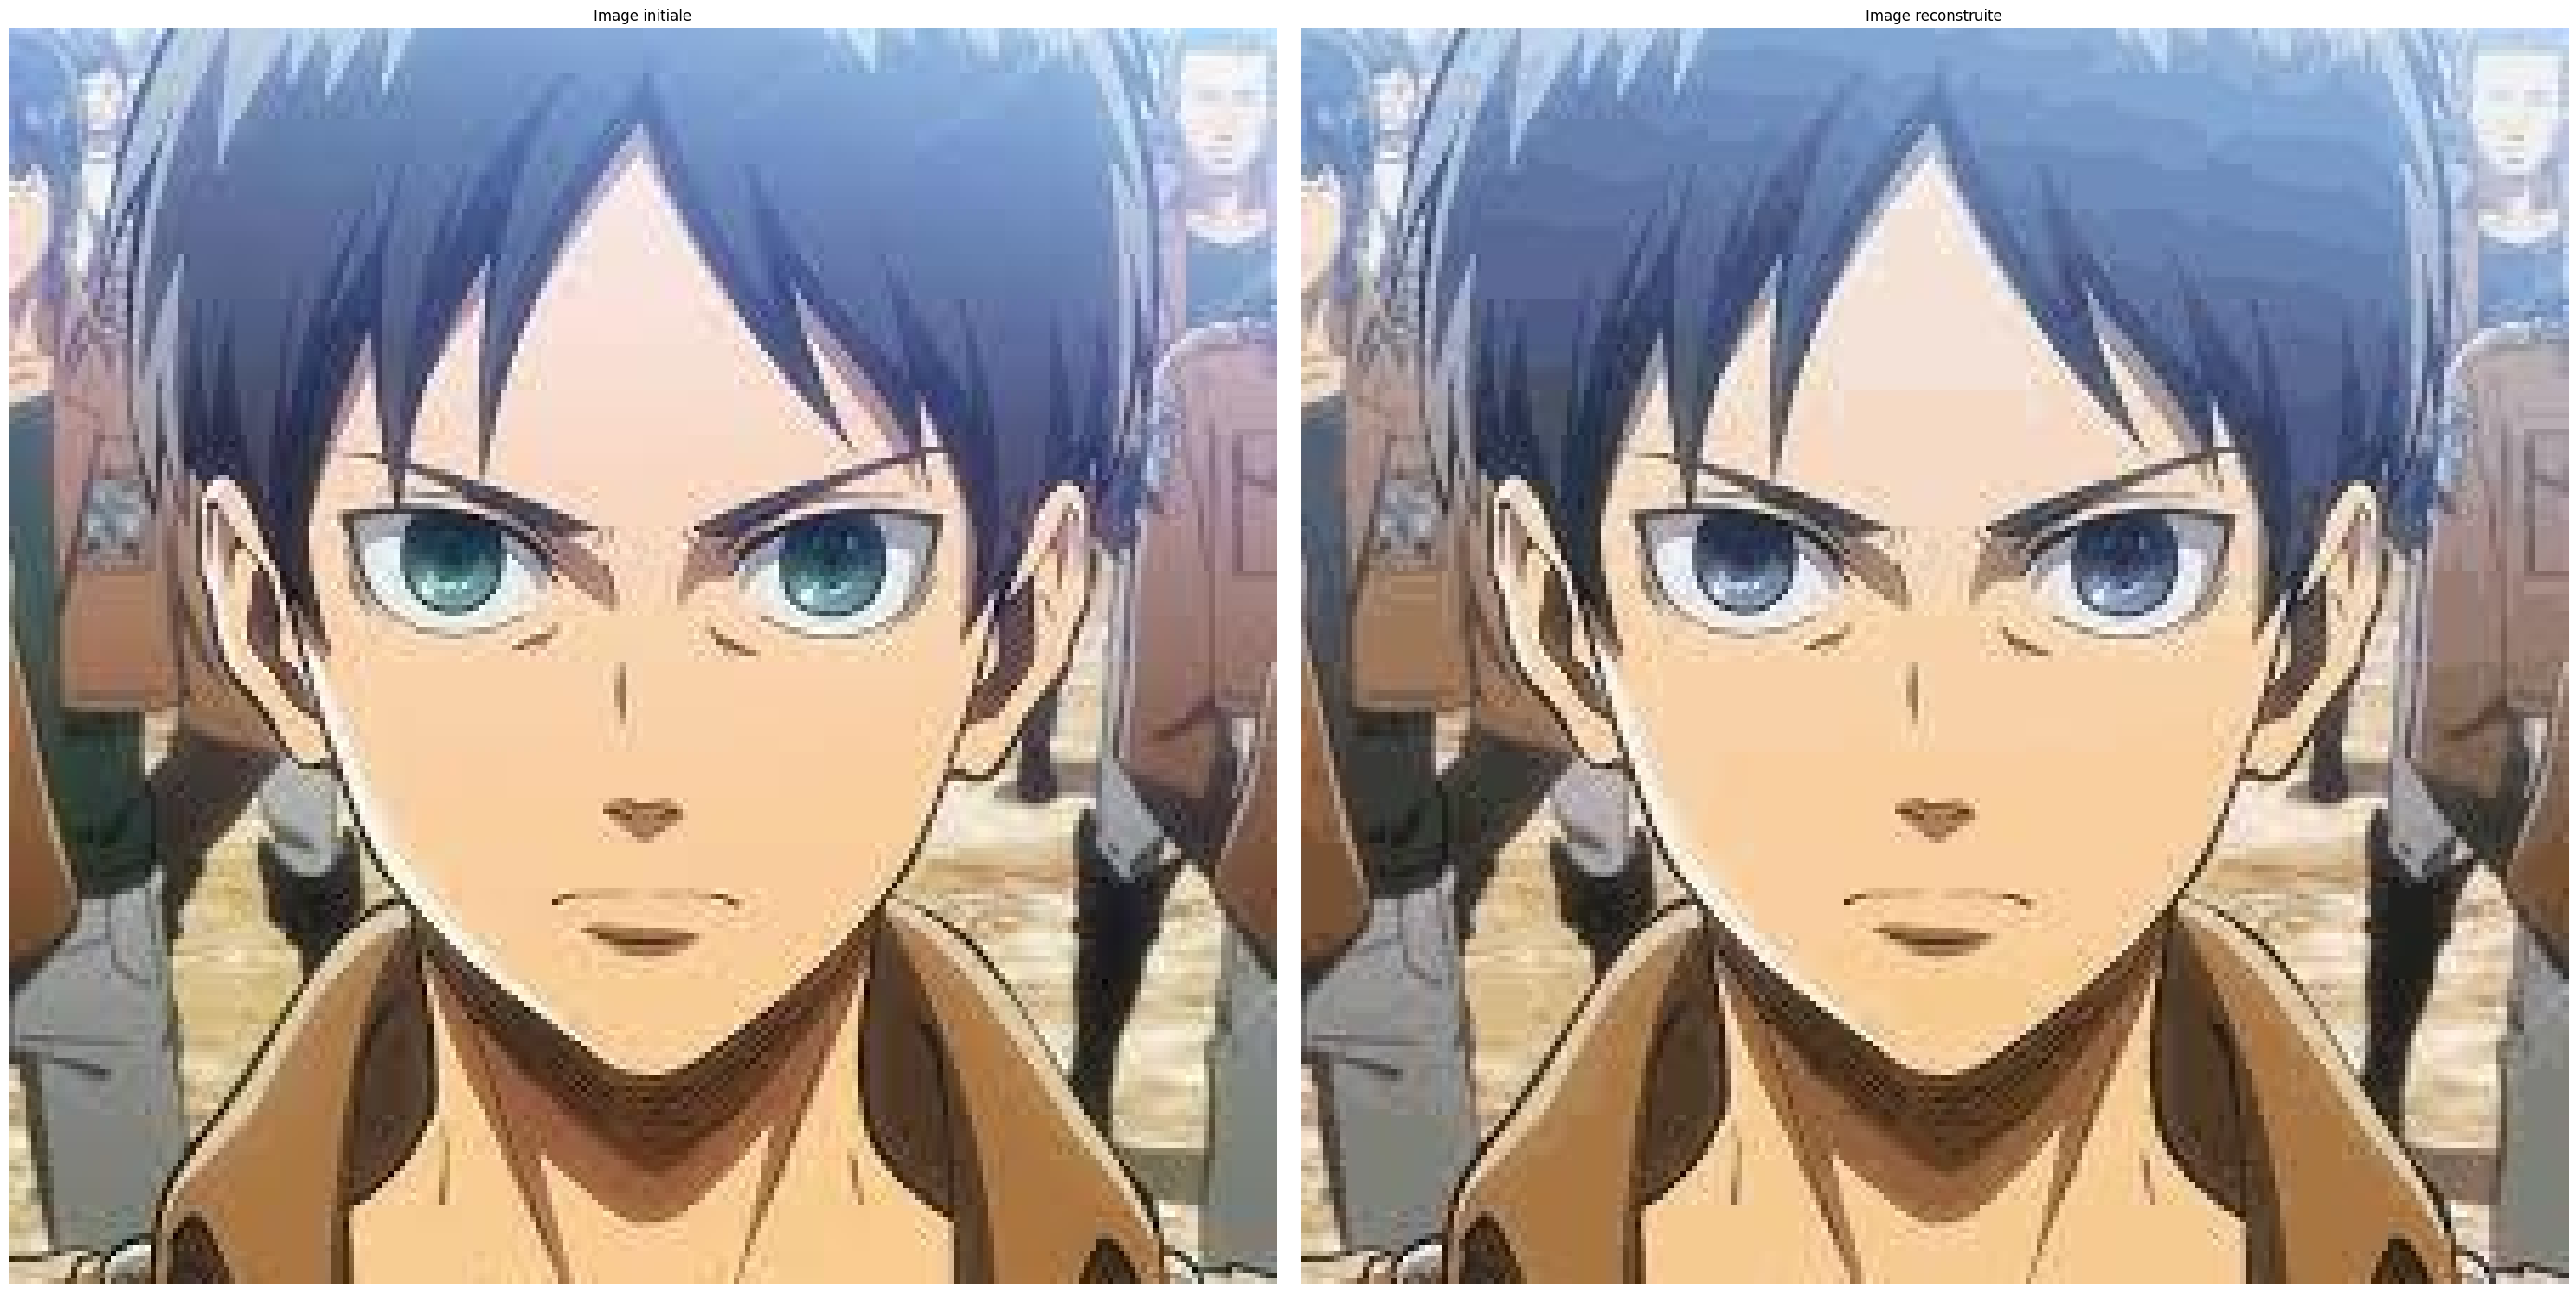

In [76]:
plot_images(input_image_path, output_image_path)

## $Mean$ $Square$ $Error$ $(MSE):$ $Erreur$ $Quadratique$ $Moyenne$

In [82]:
erreur = MSE(input_image_path, output_image_path)
print(f"L'erreur quadratique moyenne (MSE) est: {erreur}")

L'erreur quadratique moyenne (MSE) est: 63.18967181467181


## $Taux$ $de$ $compression$ $par$ $rapport$ $aux$ $données$ $des$ $fichiers$

In [83]:
taux = compression_ratio(input_image_path, input_irm_path)
print(f"Taux de compression par rapport aux données (l'entête exclue): {100 * taux} %")

Taux de compression par rapport aux données (l'entête exclue): -14.561883311883307 %
